# Data Analytics
Kassio machado

**Road Map, Questions and Directions**
- Study the variations of geographic preference of city inhabitants. How it varies according to weather variables, such as **temperature and occurrences of rain and snow**.
- Create a model to classify the sets of places;
- Study the transitions betweens places, if there is effect of weather on them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import math
import json
import numpy
import colorama
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
RESET = colorama.Fore.RESET + colorama.Back.RESET
RED = colorama.Fore.YELLOW + colorama.Back.RED
BLUE = colorama.Fore.WHITE + colorama.Back.BLUE
GREEN = colorama.Fore.WHITE + colorama.Back.GREEN
print RED, 'Error Sample Message', RESET
print BLUE, 'Information Sample Message', RESET
print GREEN, 'Information Sample Message', RESET

 Error Sample Message 
 Information Sample Message 
 Information Sample Message 


# City

In [4]:
city = 'London'
print GREEN, city, RESET

 London 


<img src="ilustrations/weather-icon.gif" alt="Instagram" style="width: 300px;"/>
# Weather Data
Source: Weather Underground - https://www.wunderground.com/weather/api/

In [11]:
weatherDir = 'data/weather/'
weatherFiles = {'New_York':'uweather-new_york.json', 
                'Chicago':'uweather-chicago.json', 
                'London':'uweather-london.json', 
                'Paris':'uweather-paris.json',
                'Sao_Paulo':'uweather-sao_paulo.json', 
                'Sydney':'uweather-sydney.json',
                'Tokyo':'uweather-tokyo.json',
               'Istanbul':'uweather-istanbul.json'}

In [8]:
def loadWeatherData(filename, dateKeyPattern='%y-%m-%d'):
    """
        Loads the weather data from JSON files imported from
        Weather Underground Source. It returns a dictionary of 
        indexed by dates (dateKeyPattern parameter) and 
        items are tuples of temperature (min, mean, max).
    """

    print BLUE, 'Loading', filename, RESET
    originalPattern = '%B %d, %Y'
    invalidSamples = 0
    weatherData = dict()
    inputfile = open(filename, 'r')
    for line in tqdm(inputfile, disable=True):
        data = json.loads(line.replace('\n', ''))
        dt = data['history']['date']['pretty']
        dt = datetime.datetime.strptime(dt, originalPattern)
        summary = data['history']['dailysummary'][0]
        try:
            tmin = float(summary['mintempm'])
            tmax = float(summary['maxtempm'])
            tmean = float(summary['meantempm'])
        except ValueError:
            invalidSamples += 1
            continue
        dtkey = dt.strftime(dateKeyPattern)
        weatherData[dtkey] = (tmin, tmean, tmax)
    if invalidSamples > 0:
        print RED, invalidSamples, 'Invalid samples', RESET
    print GREEN, 'Done!', RESET
    return weatherData
dataWeather = loadWeatherData(weatherDir + weatherFiles[city])

 Loading data/weather/uweather-london.json 
 Done! 


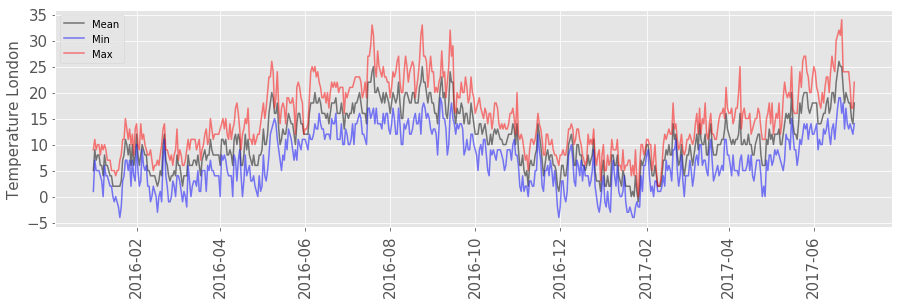

In [9]:
def plotWeatherTimeline(dataWeather, city, dateKeyPattern='%y-%m-%d'):
    """
        Plots the timeline of weather available on dataset files
        - showing min, mean and max temperatures daily.
    """
    timeline = sorted(dataWeather.keys())
    timeTicks = [datetime.datetime.strptime(t, dateKeyPattern) for t in timeline]
    plt.figure(figsize=(15,4))
    data = [dataWeather[t][1] for t in timeline]
    plt.plot(timeTicks, data, label='Mean', color='black', alpha=0.5)
    data = [dataWeather[t][0] for t in timeline]
    plt.plot(timeTicks, data, label='Min', color='blue', alpha=0.5)
    data = [dataWeather[t][2] for t in timeline]
    plt.plot(timeTicks, data, label='Max', color='red', alpha=0.5)
    plt.ylabel('Temperature ' + city, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    plt.show()
    return
plotWeatherTimeline(dataWeather, city)

In [27]:
def loadSevereTemperatures(dataWeather, mode='mean'):
    """
        Search for differences of temperature that
        exceed the expected among two consecutive days.
        The mode parameter define if the functions evaluates
        the mean or max temperature of the day - requires the
        weather dataset previously loaded.
    """
    if mode == 'mean': 
        index = 1
    else:
        mode = 'max'
        index = 2
    timeline = sorted(dataWeather)
    diffs = list()
    for d1, d2 in zip(timeline, timeline[1:]):
        d = sorted([dataWeather[d1][index], dataWeather[d2][index]])
        dif = d[1] - d[0]
        data = (dif, d1, dataWeather[d1][index], d2, dataWeather[d2][index])
        diffs.append(data)

    data = [abs(d[0]) for d in diffs]
    stdDif = numpy.std(data)
    meanDif = numpy.mean(data)
    maxDiff = meanDif + stdDif
    print GREEN, 'Maximun Difference of', mode.upper(), 'Temp. among 2 consecutive days:', maxDiff, RESET

    diffs = sorted(diffs, key=lambda k:abs(k[0]), reverse=True)
    data = list()
    for dif in diffs:
        d = abs(dif[0])
        if d > maxDiff:
            data.append(dif)
    return data

dataMaxTemperatures = loadSevereTemperatures(dataWeather, 'max')

 Maximun Difference of MAX Temp. among 2 consecutive days: 3.8756100303 


Temperatures (based on daily mean):
Min: -1.0 Max: 26.0
Mean: 26.0 STD: 5.64475030329 


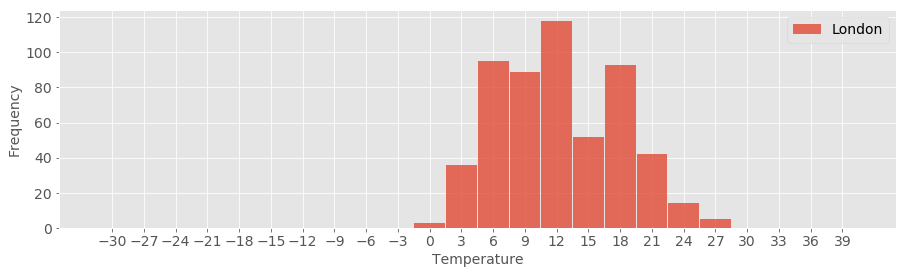

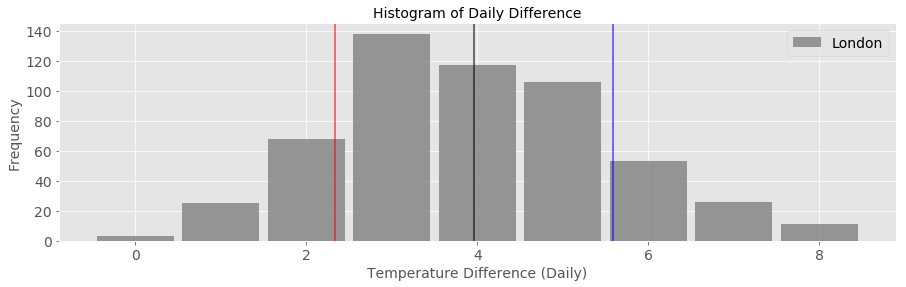

 Daily Variance: 3.95795246801 1.62590596698 


In [25]:
def plotWeatherDetails(dataWeather, city, scale=5):
    """
        Plots the histogram of temperatures rounded
        according to the scale paramenter. Additionally,
        it plots the histogram of daily difference of 
        min and max temperature registered daily and
        returns the details of temperature in dict.
    """
    details = dict()
    timeline = sorted(dataWeather.keys())
    dataRaw = [dataWeather[t][1] for t in timeline]
    data = [int(math.ceil(t/scale)*scale) for t in dataRaw]
    details['min'] = min(dataRaw)
    details['max'] = max(dataRaw)
    details['mean'] = numpy.mean(dataRaw)
    details['std'] = numpy.std(dataRaw)
    print GREEN + 'Temperatures (based on daily mean):'
    print 'Min:', details['min'], 'Max:', details['max']
    print 'Mean:', details['max'], 'STD:', details['std'], RESET
    
    plt.figure(figsize=(15,4))
    pdf, edges, = numpy.histogram(data, bins=range(-30, 45, scale))
    plt.bar(edges[:-1], pdf, width=scale - 0.1, alpha=0.8, label=city)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlabel('Temperature', fontsize=14)
    plt.xticks(edges[:-1], fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    plt.figure(figsize=(15,4))
    data = [dataWeather[t][2] - dataWeather[t][1] for t in timeline]
    pdf, edges, = numpy.histogram(data, bins=range(0, 10, 1))
    plt.bar(edges[:-1], pdf, width=0.9, alpha=0.8, label=city, color='gray')
    meanDiff = numpy.mean(data)
    stdDiff = numpy.std(data)
    details['mean-diff'] = meanDiff
    details['std-diff'] = stdDiff
    plt.axvline(details['mean-diff'], color='black', alpha=0.7)
    plt.axvline(details['mean-diff'] + details['std-diff'], color='blue', alpha=0.7)
    plt.axvline(details['mean-diff'] - details['std-diff'], color='red', alpha=0.7)
    plt.title('Histogram of Daily Difference', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlabel('Temperature Difference (Daily)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    print GREEN, 'Daily Min-Max Variance:', details['mean-diff'], details['std-diff'], RESET
    return details
weatherDetails = plotWeatherDetails(dataWeather, city, scale=3)

<img src="ilustrations/instagram-icon.gif" alt="Instagram" style="width: 300px;"/>
# Social Media Data
Source: Instagram and Twitter

**Instagram CSV Files - Columns**

**URL-Files:** *id_sample, id_user, ISO Alpha-2, url_sample, twitter_url_place, twitter_place_name, UTC Date & Time*
**URL-Resolved-Files:** *id_sample, url_sample, url_place, place_name, user_name*

OBS: url_place: can be the string 'not-available' in case of sample not avaible online  anymore

In [17]:
def loadInstagramFilenames(city):
    """
        Create the array of string of the filenames
        of the datasets.
    """
    filenames = list()
    baseFolder = 'data/'
    sufix = '-tweets-instagram-url-' + city.upper() + '.csv'
    dates = ['2016-06-16', '2016-07-11', '2016-08-05', 
                '2016-08-18', '2016-09-12', '2016-10-05', 
                '2016-11-07', '2016-12-04', '2016-12-14', 
                '2017-01-09', '2017-02-15', '2017-03-17',
                '2017-03-19', '2017-04-17', '2017-05-15']
    for d in dates:
        fname = baseFolder + d + sufix
        filenames.append(fname)
    return filenames
instragramFiles = loadInstagramFilenames(city)

In [19]:
def loadInstagramURLs(inputfiles, completeName=True):
    """
        Loads the files of resolved urls which indicate the place
        where the photos were taken. It returns a dict where the keys
        are the id of tweet and items are the urls of places, 
        without the url base.
    """
    urlBase = 'https://www.instagram.com/explore/locations/'    
    dictSamples = dict()
    for filename in inputfiles:
        if completeName:
            filename = filename.replace('.csv', '-resolved.csv')
        f = open(filename, 'r')
        nlines = 0
        for i in f:
            nlines += 1
        f.seek(0)
        reader = csv.reader(f)
        for data in tqdm(reader, total=nlines, disable=True):
            if data[2] != 'not-available':
                urlPlace = data[2].replace(urlBase, '')
                placeName = data[3]
                dictSamples[data[0]] = (urlPlace, placeName)
        alias = filename.split('/')[-1]
        print BLUE, 'Load:', alias, len(dictSamples), 'Samples', RESET
    print GREEN, 'Done! Total Samples:', len(dictSamples), RESET
    return dictSamples

dataInstagramURL = loadInstagramURLs(instragramFiles)

 Load: 2016-06-16-tweets-instagram-url-LONDON-resolved.csv 878 Samples 
 Load: 2016-07-11-tweets-instagram-url-LONDON-resolved.csv 124467 Samples 
 Load: 2016-08-05-tweets-instagram-url-LONDON-resolved.csv 175949 Samples 
 Load: 2016-08-18-tweets-instagram-url-LONDON-resolved.csv 288077 Samples 
 Load: 2016-09-12-tweets-instagram-url-LONDON-resolved.csv 403601 Samples 
 Load: 2016-10-05-tweets-instagram-url-LONDON-resolved.csv 435227 Samples 
 Load: 2016-11-07-tweets-instagram-url-LONDON-resolved.csv 569446 Samples 
 Load: 2016-12-04-tweets-instagram-url-LONDON-resolved.csv 604383 Samples 
 Load: 2016-12-14-tweets-instagram-url-LONDON-resolved.csv 712335 Samples 
 Load: 2017-01-09-tweets-instagram-url-LONDON-resolved.csv 877315 Samples 
 Load: 2017-02-15-tweets-instagram-url-LONDON-resolved.csv 1035950 Samples 
 Load: 2017-03-17-tweets-instagram-url-LONDON-resolved.csv 1193413 Samples 
 Load: 2017-03-19-tweets-instagram-url-LONDON-resolved.csv 1193439 Samples 
 Load: 2017-04-17-tweets-

In [21]:
def mergeInstagramData(inputfiles, dataInstagramURL):
    """
        Loads the original dataset files and combine the data
        with resolved URLs. 
        Requires the preloaded data from resolved URLS.
    """
    dataInstagram = dict()
    for filename in inputfiles:
        alias = filename.split('/')[-1]
        print BLUE, 'Load:', alias, RESET
        f = open(filename, 'r')
        nlines = 0
        for i in f:
            nlines += 1
        f.seek(0)
        reader = csv.reader(f)
        for data in tqdm(reader, total=nlines, disable=True):
            try:
                urlPlace, placeName = dataInstagramURL[data[0]]
            except KeyError:
                # KeyError in case of sample not available or not resolved
                continue
            except ValueError:
                # ValueError in case of duplicated sample lines
                continue
            try:
                dataInstagram[data[0]] = (data[6], urlPlace, placeName, data[1])
                # (dateTime, urlPlace, placeName, idUser)
            except IndexError:
                print RED, 'CORRUPTED LINE!', RESET
                print data
                return
    print GREEN, 'Done!', RESET
    return dataInstagram

dataInstagram = mergeInstagramData(instagramFiles, dataInstagramURL)

 Load: 2016-06-16-tweets-instagram-url-LONDON.csv 
 Load: 2016-07-11-tweets-instagram-url-LONDON.csv 
 Load: 2016-08-05-tweets-instagram-url-LONDON.csv 
 Load: 2016-08-18-tweets-instagram-url-LONDON.csv 
 Load: 2016-09-12-tweets-instagram-url-LONDON.csv 
 Load: 2016-10-05-tweets-instagram-url-LONDON.csv 
 Load: 2016-11-07-tweets-instagram-url-LONDON.csv 
 Load: 2016-12-04-tweets-instagram-url-LONDON.csv 
 Load: 2016-12-14-tweets-instagram-url-LONDON.csv 
 Load: 2017-01-09-tweets-instagram-url-LONDON.csv 
 Load: 2017-02-15-tweets-instagram-url-LONDON.csv 
 Load: 2017-03-17-tweets-instagram-url-LONDON.csv 
 Load: 2017-03-19-tweets-instagram-url-LONDON.csv 
 Load: 2017-04-17-tweets-instagram-url-LONDON.csv 
 Load: 2017-05-15-tweets-instagram-url-LONDON.csv 
 Done! 


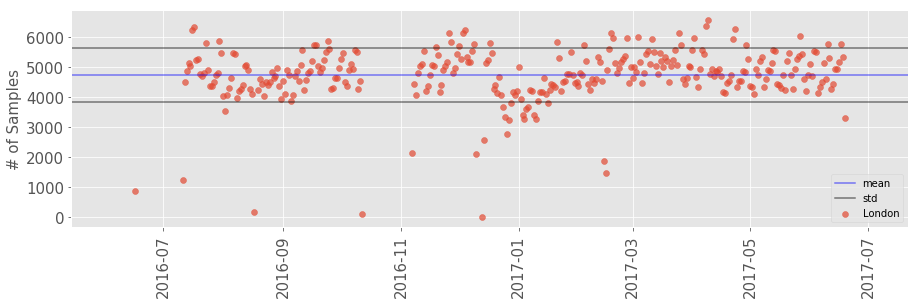

In [22]:
def plotInstagramTimeline(dataInstagram, city):
    data = dict()
    for i in dataInstagram:
        sample = dataInstagram[i]
        dt = sample[0].split(' ')[0]
        try:
            data[dt].add(i)
        except KeyError:
            data[dt] = {i}
    timeline = sorted(data)
    datapoints = [len(data[i]) for i in timeline]
    mean = numpy.mean(datapoints)
    std = numpy.std(datapoints)
    timeline = [datetime.datetime.strptime(t, '%y-%m-%d') for t in timeline]
    plt.figure(figsize=(15,4))
    plt.scatter(timeline, datapoints, alpha=0.7, label=city)
    plt.axhline(mean, alpha=0.5, color='blue', label='mean')
    plt.axhline(mean + std, alpha=0.5, color='black', label='std')
    plt.axhline(mean - std, alpha=0.5, color='black')
    plt.ylabel('# of Samples', fontsize=15)
    plt.xticks(rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    plt.show()
    return

plotInstagramTimeline(dataInstagram, city)  

# Analytics

In [23]:
def groupSamplesSpatioTemporal(dataInstagram, dateKeyFormat='%y-%m-%d'):
    """
        Loads the samples from dataInstagram and group them
        according to the place-url and dateKeyFormat.
        In other words: it returns a dict indexed by date 
        and followed by places urls, where the items represent
        the ammount of samples.
    """
    dataTimeline = dict()
    for i in tqdm(dataInstagram, 'Grouping'):
        sample = dataInstagram[i]
        dateKey = sample[0].split(' ')[0]
        placeURL = sample[1]
        try:
            dataTimeline[dateKey][placeURL] += 1
        except KeyError:
            if dateKey not in dataTimeline:
                dataTimeline[dateKey] = dict()
            dataTimeline[dateKey][placeURL] = 1
    return dataTimeline

In [24]:
dataSpatiotemporal = groupSamplesSpatioTemporal(dataInstagram)

Grouping: 100%|██████████| 1502612/1502612 [00:04<00:00, 336266.15it/s]


In [25]:
def loadTopPopularityPlaces(dataInstagram, top=100):
    dataPlaces = dict()
    for n in dataInstagram:
        sample = dataInstagram[n]
        try:
            dataPlaces[sample[1]] += 1
        except KeyError:
            dataPlaces[sample[1]] = 1
    print GREEN, '# of Places:', len(dataPlaces), RESET
    print GREEN, 'Done!', RESET
    return dataPlaces
dataTopPlaces = loadTopPopularityPlaces(dataInstagram)

 # of Places: 69673 
 Done! 


# Top Places

In [26]:
topPlaces = sorted(dataTopPlaces.keys(), key=lambda k:dataTopPlaces[k], reverse=True)
for i, p in enumerate(topPlaces[:10]):
    print i + 1, p.split('/')[1], dataTopPlaces[p]

1 london-united-kingdom 247932
2 tower-bridge 10581
3 shoreditch 8202
4 the-o2 7896
5 hyde-park 6466
6 wembley-stadium 6413
7 buckingham-palace 5771
8 covent-garden-london 5747
9 trafalgar-square 5509
10 big-ben 5369


 Weather Tipping Point 11.2449725777 
 Tipping Point Set of Places:
BEFORE 43853 places
AFTER 52421 places
Intersection 26601 places
Intersec. Samples: 93 % 


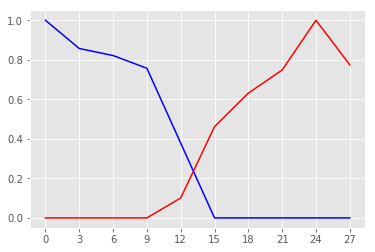

In [29]:
def plotWeatherTippingPoint(dataWeather, weatherDetails, dataSpatiotemporal, topPlaces):
    """
        ...
    """
    PHASES = ['BEFORE', 'AFTER']
    tp = weatherDetails['mean']
    print BLUE, 'Weather Tipping Point', tp, RESET
    topPlaces = set(topPlaces)
    dataPhases = dict()
    dataTipping = dict()
    for k in PHASES:
        dataPhases[k] = dict()
        dataTipping[k] = set()
    
    for dateKey in dataSpatiotemporal:
        temp = dataWeather[dateKey][1]
        k = PHASES[0] if temp <= tp else PHASES[1]
        dataTipping[k].update(topPlaces.intersection(dataSpatiotemporal[dateKey].keys()))
    
    intersection = dataTipping[PHASES[0]].intersection(dataTipping[PHASES[1]])
    totalSamples = sum([sum(dataSpatiotemporal[d].values()) for d in dataSpatiotemporal])
    intersectSamples = 0
    for dateKey in dataSpatiotemporal:
        for p in intersection:
            try:
                intersectSamples += dataSpatiotemporal[dateKey][p]
            except KeyError:
                continue
                
    print GREEN, 'Tipping Point Set of Places:'
    print PHASES[0], len(dataTipping[PHASES[0]]), 'places'
    print PHASES[1], len(dataTipping[PHASES[1]]), 'places'
    print 'Intersection', len(intersection), 'places'
    perc = int((intersectSamples/float(totalSamples)) * 100)
    print 'Intersec. Samples:', perc, '%', RESET
    dataTipping[PHASES[0]].difference_update(intersection)
    dataTipping[PHASES[1]].difference_update(intersection)
    
    scale = 3
    tempCounter = dict()
    for dateKey in dataSpatiotemporal:
        temp = dataWeather[dateKey][1]
        temp = int(math.ceil(temp/scale)*scale)
        for k in PHASES:
            n = 0
            for p in dataTipping[k]:
                try:
                    n += dataSpatiotemporal[dateKey][p]
                except KeyError:
                    continue
            try:
                dataPhases[k][temp] += n # we can divide by # of instances of temp
                tempCounter[temp] += 1
            except KeyError:
                dataPhases[k][temp] = n
                tempCounter[temp] = 1
        
    ticks = sorted(dataPhases[PHASES[0]])
    data = [dataPhases[PHASES[0]][t]/tempCounter[t] for t in ticks] # normalizing
    data = normalizeMax(data, max(data))
    plt.plot(ticks, data, color='blue')
    data = [dataPhases[PHASES[1]][t]/tempCounter[t] for t in ticks]
    data = normalizeMax(data, max(data))
    plt.plot(ticks, data, color='red')
    plt.xticks(ticks)
    plt.show()
        
    return
plotWeatherTippingPoint(dataWeather, weatherDetails, dataSpatiotemporal, topPlaces)

In [28]:
def normalizeMax(dataList, maxValue):
    values = []
    maxValue = float(maxValue)
    for x in dataList:
        try:
            v = x/maxValue
        except ZeroDivisionError:
            v = 0
        values.append(v)
    return values

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Temperature Spectrum [0, 5, 10, 15, 20, 25, 30]
[ 0.30974458  0.16580135  0.15917     0.12890051  0.11135871  0.07087228
  0.05415257]
[ 0.30974458  0.47554593  0.63471593  0.76361644  0.87497515  0.94584743
  1.        ]


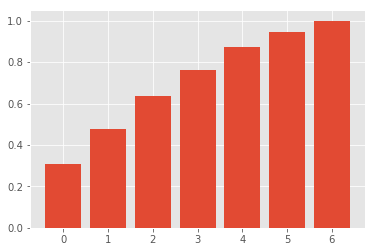

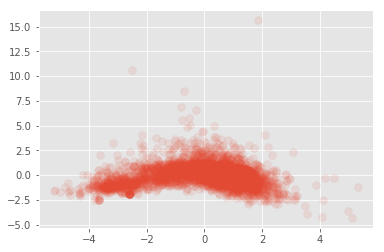

In [31]:
def loadPCA(dataSpatiotemporal, dataWeather, topPlaces, roundFactor=5):
    tempSpectrum = set()
    dataPCA = dict()
    for dateKey in dataSpatiotemporal:
        temp = dataWeather[dateKey][1]
        temp = int(math.ceil(temp/roundFactor)*roundFactor)
        tempSpectrum.add(temp)
        for p in dataSpatiotemporal[dateKey]:
            try:
                dataPCA[p][temp] += dataSpatiotemporal[dateKey][p]
            except:
                if p not in dataPCA:
                    dataPCA[p] = dict()
                dataPCA[p][temp] = dataSpatiotemporal[dateKey][p]

    tempSpectrum = sorted(tempSpectrum)
    print 'Temperature Spectrum', tempSpectrum
    for p in dataPCA:
        s = list()
        for t in tempSpectrum:
            try:
                s.append(dataPCA[p][t])
            except KeyError:
                s.append(0)
        dataPCA[p] = normalizeMax(s, max(s))
        
    pcadata = [dataPCA[p] for p in topPlaces[:4000]]
    x = scale(pcadata)
    pca = PCA(n_components=len(tempSpectrum))
    pca.fit(x)
    var = pca.explained_variance_ratio_
    c = numpy.cumsum(pca.explained_variance_ratio_)
    plt.figure()
    plt.bar(range(len(c)), c, linewidth=1)
    print pca.explained_variance_ratio_
    print c
    xt = pca.transform(x)
    plt.figure()
    plt.scatter(xt[:,0], xt[:,1], s=60, alpha=0.1)
    return pcadata

dataPCA = loadPCA(dataSpatiotemporal, dataWeather, topPlaces)

Temperature Spectrum [0, 5, 10, 15, 20, 25, 30]
Place Spectrum 69673
 Variance Explained:
[  3.65538735e-01   2.71331374e-01   1.82653898e-01   9.25897477e-02
   5.35287330e-02   3.43575129e-02   5.67210854e-31]
[ 0.36553873  0.63687011  0.81952401  0.91211375  0.96564249  1.          1.        ] 


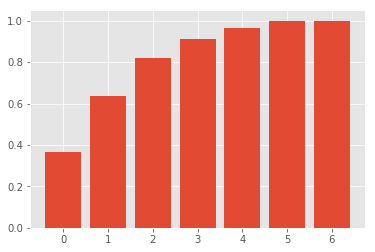

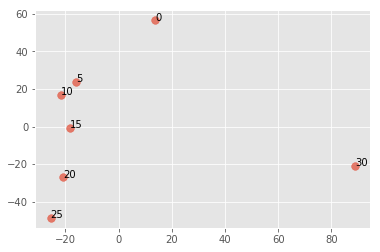

In [32]:
def loadPCA(dataSpatiotemporal, dataWeather, topPlaces, roundFactor=5):
    dataPCA = dict()
    tempSpectrum = set()
    placesSpectrum = set()    
    
    for dateKey in dataSpatiotemporal:
        temp = dataWeather[dateKey][1]
        temp = int(math.ceil(temp/roundFactor)*roundFactor)
        tempSpectrum.add(temp)
        placesSpectrum.update(dataSpatiotemporal[dateKey].keys())
        for p in dataSpatiotemporal[dateKey]:
            try:
                dataPCA[temp][p] += dataSpatiotemporal[dateKey][p]
            except:
                if temp not in dataPCA:
                    dataPCA[temp] = dict()
                dataPCA[temp][p] = dataSpatiotemporal[dateKey][p]

    tempSpectrum = sorted(tempSpectrum)
    placesSpectrum = sorted(placesSpectrum)
    print 'Temperature Spectrum', tempSpectrum
    print 'Place Spectrum', len(placesSpectrum)
    for t in dataPCA:
        s = list()
        for p in topPlaces[:4000]: #placesSpectrum:
            try:
                s.append(dataPCA[t][p])
            except KeyError:
                s.append(0)
        dataPCA[t] = normalizeMax(s, max(s))
        
    pcadata = [dataPCA[t] for t in sorted(dataPCA)]
    x = scale(pcadata)
    pca = PCA(n_components=len(tempSpectrum))
    pca.fit(x)
    var = pca.explained_variance_ratio_
    c = numpy.cumsum(pca.explained_variance_ratio_)
    print GREEN, 'Variance Explained:'
    print pca.explained_variance_ratio_
    print c, RESET
    plt.figure()
    plt.bar(range(len(c)), c, linewidth=1)
    xt = pca.transform(x)
    plt.figure()
    plt.scatter(xt[:,0], xt[:,1], s=60, alpha=0.7)
    for x, y, t in zip(xt[:,0], xt[:,1], sorted(dataPCA)):
        plt.annotate(t, xy=(x, y), xytext=(x, y))
    return pcadata

dataPCA = loadPCA(dataSpatiotemporal, dataWeather, topPlaces)

In [ ]:
dataWeather = loadWeatherData(weatherFiles[0])



































